In [1]:
import numpy as np
import h5py
import pyemma
import time

from decimal import Decimal
import matplotlib.pyplot as plt

from utilities import walker_ancestors
from utilities import fe_to_kd_3d_solution
from utilities import macrostate_classifier

from westpa_msm_functions_cftr import h5_2_transitions_forpyemma_webins
from westpa_msm_functions_cftr import plot_2d_pc_webins
from westpa_msm_functions_cftr import build_pyemma_msm_webins

loading data for 100 westpa rounds
loaded data for 2648 transitions in 0.2439732551574707 seconds
built msm in 0.04890108108520508 seconds


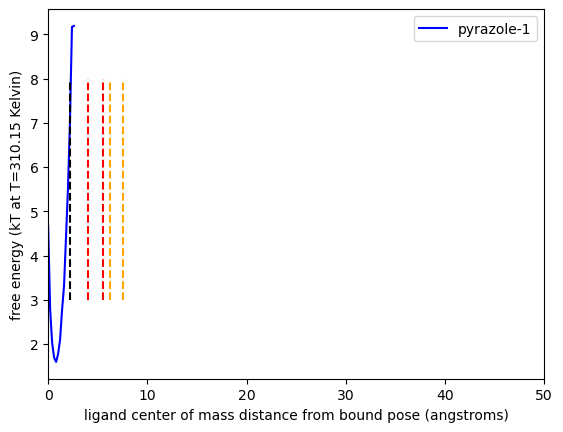

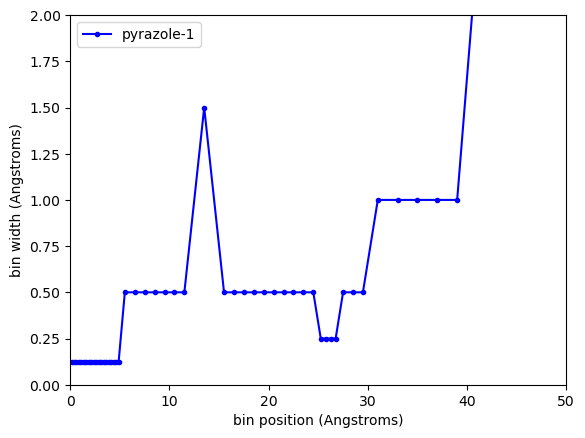

In [6]:
#specify input file

cftr_west = "/home/jonathan/Documents/grabelab/cftr/chloe-data"
cftr_refpc = "/home/jonathan/Documents/grabelab/cftr/refeaturization"

h5paths_names = [[f"{cftr_west}/wstp_cftr_1_degrabo/west-040925.h5", f"{cftr_refpc}/nonlip_glpg_1", "pyrazole-1", "blue", [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]]
                  # [f"{cftr_west}/wstp_cftr_2_wynton/west-040925.h5", f"{cftr_refpc}/nonlip_glpg_2", "pyrazole-2", "cyan", [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  # [f"{cftr_west}/wstp_lip_glpg_1/west-040925.h5", f"{cftr_refpc}/lip_glpg_1", "undecanol-1", "red",       [0, 1, 3, 5, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  # [f"{cftr_west}/wstp_lip_glpg_2/west-040925.h5", f"{cftr_refpc}/lip_glpg_2", "undecanol-2", "orange",    [0,1,1.3,1.5,1.7,2,2.2,2.4,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,25.5,26,26.5,27,28,29,30,32,34,36,38,40,41,50]]
]

#westpa rounds to load
minround = 0
maxround = 100

#parameters related to data processing
n_walkers = 4
uniform_we_bins = np.arange(0,50,0.2)
#np.arange(0,6,.02) #for refeaturized data
n_pc2_vals = 1 

threshold = 5
plot_bayesian_error_bars = False #do not use until the log(mean) vs mean(log) issue is fixed

#saving figure
#a value of "" saves no figure
figure_name = ""

legend = []

#build msms
for h5pn in h5paths_names:  
    we_bins = uniform_we_bins #h5pn[4] #
    
    trjs, pclims, pcinit, trjs_binned_all0, plot_data_1 = build_pyemma_msm_webins(h5pn[0], "", minround, maxround, n_pc2_vals, we_bins, threshold, n_walkers, plot_bayesian_error_bars, figure_name)

    #binbounds = h5pn[4]
    #bincenters = [(binbounds[i] + binbounds[i+1])/2 for i in range(len(binbounds)-1)]
    binwidths = [(we_bins[i+1] - we_bins[i])/2 for i in range(len(we_bins)-1)]
    #print(len(binwidths))
    #print(len(plot_data_1[1]))

    plot_data_permeter = [-np.log(np.exp(-g)/bw) for g, bw in zip(plot_data_1[1], binwidths)]
    
    plt.plot(plot_data_1[0], plot_data_1[1], color = h5pn[3])
    #plt.plot(plot_data_1[0], plot_data_permeter, color = h5pn[3], linestyle="dotted")

    legend.append(h5pn[2])
    #legend.append(h5pn[2]+"corrected")


plt.plot([2.2, 2.2], [3,8], color="black", linestyle="dashed")
plt.plot([4.0, 4.0], [3,8], color="red", linestyle="dashed")
plt.plot([5.5, 5.5], [3,8], color="red", linestyle="dashed")

#plt.plot([2.2, 2.2], [3,11], color="orange", linestyle="dashed")
plt.plot([6.2, 6.2], [3,8], color="orange", linestyle="dashed")
plt.plot([7.5, 7.5], [3,8], color="orange", linestyle="dashed")

plt.legend(legend)
plt.xlim(0,50)

plt.ylabel("free energy (kT at T=310.15 Kelvin)")
plt.xlabel("ligand center of mass distance from bound pose (angstroms)")

plt.savefig("dissociation_landscape_full.png", dpi=600)

plt.show()

#---------------------------------------------------------------------------------
#plot bin widths
#---------------------------------------------------------------------------------

linestyles = ["solid", "dashed", "dotted", "dashdot"]

legend = []

i = 0
for h5pn in h5paths_names:  

    binbounds = h5pn[4]
    bincenters = [(binbounds[i] + binbounds[i+1])/2 for i in range(len(binbounds)-1)]
    binwidths = [(binbounds[i+1] - binbounds[i])/2 for i in range(len(binbounds)-1)]
    
    plt.plot(bincenters, binwidths, marker=".", linestyle=linestyles[i], color = h5pn[3])
    plt.xlim(0,50)
    plt.ylim(0,2)

    legend.append(h5pn[2])
    i += 1

plt.xlabel("bin position (Angstroms)")
plt.ylabel("bin width (Angstroms)")

plt.legend(legend)


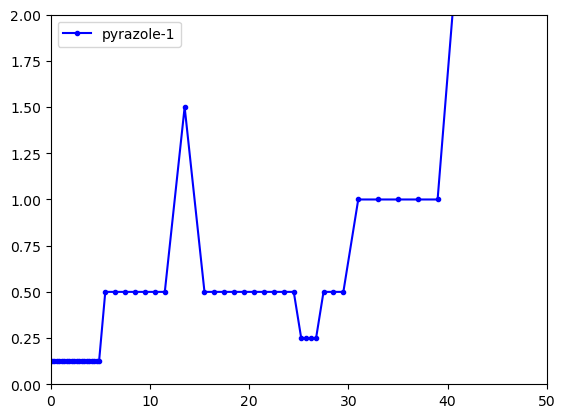

In [3]:

linestyles = ["solid", "dashed", "dotted", "dashdot"]

legend = []

i = 0
for h5pn in h5paths_names:  

    binbounds = h5pn[4]
    bincenters = [(binbounds[i] + binbounds[i+1])/2 for i in range(len(binbounds)-1)]
    binwidths = [(binbounds[i+1] - binbounds[i])/2 for i in range(len(binbounds)-1)]
    
    plt.plot(bincenters, binwidths, marker=".", linestyle=linestyles[i], color = h5pn[3])
    plt.xlim(0,50)
    plt.ylim(0,2)

    legend.append(h5pn[2])
    i += 1

plt.legend(legend)

In [4]:
#look at plateau along dissociation trajectory for both lipidated molecules
#also look at plateau selected at random
#The refeaturized trace going down to 1 is just a bug because mdtraj compute center of mass does not account for periodic boundaries

loading data for 64 westpa rounds
loaded data for 28896 transitions in 2.0641417503356934 seconds
built msm in 0.5628092288970947 seconds


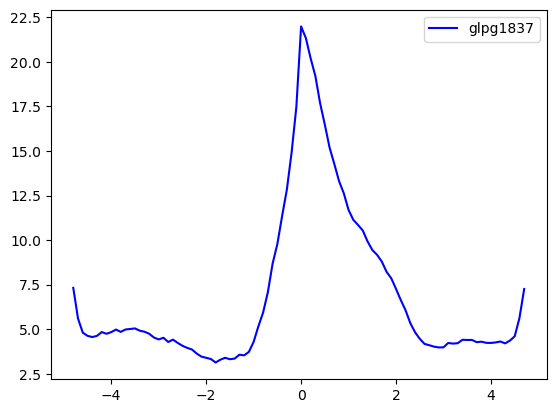

In [5]:
#specify input file

cftr_west = "/home/jonathan/Documents/grabelab/cftr/ligand-simulations/"

h5paths_names = [[f"{cftr_west}/nonlipidated/westpa/westpa-63/west-041525-1055.h5", "glpg1837", "blue"]]

#westpa rounds to load
minround = 150
maxround = -1

#parameters related to data processing
n_walkers = 6
we_bins = np.arange(-5,5,0.1)
#np.arange(0,6,.02) #for refeaturized data
n_pc2_vals = 1 

threshold = 5
plot_bayesian_error_bars = False #do not use until the log(mean) vs mean(log) issue is fixed

#saving figure
#a value of "" saves no figure
figure_name = ""

legend = []

#build msms
for h5pn in h5paths_names:  
    trjs, pclims, pcinit, trjs_binned_all0, plot_data_1 = build_pyemma_msm_webins(h5pn[0], "", minround, maxround, n_pc2_vals, we_bins, threshold, n_walkers, plot_bayesian_error_bars, figure_name)
    plt.plot(plot_data_1[0], plot_data_1[1], color = h5pn[2])
    legend.append(h5pn[1])
    
plt.legend(legend)
